In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [2]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

def inv_poisson(pct):
    MOI = -np.log(1-pct)
    multiple = 1-np.exp(-MOI)*(MOI+1)
    
    return multiple

In [3]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]

In [4]:
# PRM data
folder = r'..\Skyline_reports'

hsv1_ACV1 = load_herpesvirusPRMreport(os.path.join(folder, 'HSV-1_DMSO_ACV_1uM.csv'), 'HSV-1')
hsv1_ACV3 = load_herpesvirusPRMreport(os.path.join(folder, 'HSV-1_DMSO_ACV_3uM.csv'), 'HSV-1')
hcmv_CDV = load_herpesvirusPRMreport(os.path.join(folder, 'HCMV_CDV.csv'), 'HCMV')

all_data = pd.concat([hsv1_ACV1, hsv1_ACV3, hcmv_CDV], keys = ['ACV 1uM', 'ACV 3uM', 'CDV'], names = ['experiment'])
filename_mapping = all_data.reset_index()[['experiment', 'treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates


In [52]:
# titer data
plaques = pd.read_csv(r'..\data\HSV-1_plaque_assay.csv', header = [0, 1, 2], index_col=[0])
titers = (1000/plaques['Dilution factor']*plaques['Plaque count']).apply(lambda x: x*1/plaques['vol inoculum'].squeeze())

genomes = pd.read_csv(r'..\data\HSV-1_HCMV_ACV_CDV_viral_genomes.csv', index_col=[0, 1, 2, 3]).squeeze()
genomes.name = '2^-deltaCt'

cido_titers = pd.read_csv(r'..\data\HCMV_CDV_titers.csv', index_col = [0, 1, 2, 3])
cido = cido_titers[((cido_titers['% infected']/100).apply(inv_poisson)<0.05)&(cido_titers['Positive IE1 in Nuclei']>2)]['IU/ml'].apply(np.log2)

In [83]:
# TUNEL assay data
col_ids = dict(zip(range(1, 11), ['positive control', 'negative control', 'untreated', 'DMSO', 'ACV (1uM)', 'ACV (3uM)', 'CDV (1uM)', 'EX-527 (10uM)', 'CAY10602 (12.5uM)', 'Resveratrol (50uM)']))
row_ids = {4:1, 5:2, 6:3}
mrc5 = pd.read_csv(r'..\data\MRC5_TUNEL.txt', sep='\t')
# mrc5 = pd.read_csv(r'20210629_MAK_MRC5_TUNEL__2021-06-29T10_54_20-Measurement1\Evaluation1\Objects_Population - Nuclei.txt', sep='\t')

mrc5['sample'] = mrc5['Column'].map(col_ids)
mrc5['replicate'] = mrc5['Row'].map(row_ids)
mrc5 = mrc5.set_index(['sample', 'replicate', 'Field', 'Object No'])

col_ids = dict(zip(range(1, 8), ['negative control', 'positive control', 'untreated', 'DMSO', 'EX-527 (10uM)', 'CAY10602 (12.5uM)', 'Resveratrol (50uM)']))
row_ids = {1:1, 2:2, 3:3}

islk = pd.read_csv(r'..\data\iSLK219_TUNEL.txt', sep='\t', skiprows = range(9))

islk['sample'] = islk['Column'].map(col_ids)
islk['replicate'] = islk['Row'].map(row_ids)
islk = islk.set_index(['sample', 'replicate', 'Field', 'Object No'])

fluors = pd.concat([mrc5['Nuclei - Fluorescein Intensity in Nucleus Mean'], islk['Nuclei - Fluorescein Intensity in Nucleus Mean']], keys = ['MRC5', 'iSLK.219'], names = ['cell type'])
fluors.name = 'OD'

meds = fluors.unstack('sample')['positive control'].groupby('cell type').describe()['mean']
binary = fluors>300

pct_apop = (binary.groupby(['cell type', 'sample', 'replicate']).sum()/binary.groupby(['cell type', 'sample', 'replicate']).size())*100

# Normalize Data

### MS1 normalization

In [6]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(all_data.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['experiment', 'treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['experiment', 'replicate']).apply(lambda x: x/x.mean())
all_data_adj = all_data.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)


### Mean normalization

In [7]:
cols = ['treatment', 'timepoint']
all_data_norm = mean_normalize(all_data_adj.unstack(cols)).stack(cols)
all_data_avg = all_data_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
all_data_mean = all_data_avg.unstack(['replicate']).mean(axis=1)

# Export Supplemental Tables

In [8]:
temp = all_data_norm.T['ACV 1uM'].T.reset_index()
temp['treatment'] = temp['treatment'].where(lambda x: x=='DMSO', 'ACV (1uM)')
temp = temp.set_index(all_data_norm.index.names[1:]).squeeze().unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3B.csv')

temp = all_data_norm.T['ACV 3uM'].T.reset_index()
temp['treatment'] = temp['treatment'].where(lambda x: x=='DMSO', 'ACV (3uM)')
temp = temp.set_index(all_data_norm.index.names[1:]).squeeze().unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3C.csv')

temp = all_data_norm.T['CDV'].T.reset_index()
temp = temp.set_index(all_data_norm.index.names[1:]).squeeze().unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['treatment', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3D.csv')

# Make Figures

### Fig. 4A

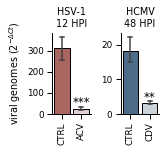

In [9]:
fig, axs = plt.subplots(figsize = (2.4, 2.2), ncols=2, sharey=False)
sns.barplot(data=genomes['HSV-1'].sort_index()[12].reset_index(), x='treatment', y='2^-deltaCt', 
            ax=axs[0], 
            palette=hsv1_palette([10, 200]), 
            order = ['control', 'acyclovir'],
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k')
sns.barplot(data=genomes['HCMV'].reset_index(), x='treatment', y='2^-deltaCt', 
            ax=axs[1], 
            palette=hcmv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k')

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].set_xticklabels(['CTRL', 'ACV'], rotation=90)
axs[1].set_xticklabels(['CTRL', 'CDV'], rotation=90)
    
axs[0].set_ylabel('viral genomes ($2^{-\u0394Ct})$')
axs[0].set_title('HSV-1\n12 HPI')
axs[1].set_title('HCMV\n48 HPI')

axs[0].text(1, genomes['HSV-1'][12].unstack('treatment')['acyclovir'].mean()+15, add_stars(TTEST(genomes['HSV-1'][12].unstack('treatment'))).values[0], ha='center', fontsize=12)
axs[1].text(1, genomes['HCMV'].unstack('treatment')['cidofovir'].mean()+.5, add_stars(TTEST(genomes['HCMV'].unstack('treatment'))).values[0], ha='center', fontsize=12)

fig.tight_layout()
fig.savefig(r'..\figures\Fig4A.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 4B

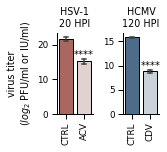

In [77]:

fig, axs = plt.subplots(figsize = (2.4, 2.2), ncols=2, sharey=False)
sns.barplot(data=titers.loc[['DMSO', 'ACV (3uM)'], :].unstack().apply(np.log2).reset_index(), 
            x='sample', 
            y=0,
            ax=axs[0],
            palette=hsv1_palette([10, 200]), 
            order = ['DMSO', 'ACV (3uM)'],
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k'
           )
sns.barplot(data=cido.reset_index(), 
            x='treatment', 
            y='IU/ml',
            ax=axs[1],
            palette=hcmv_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k'
           )
for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].set_xticklabels(['CTRL', 'ACV'], rotation=90)
axs[1].set_xticklabels(['CTRL', 'CDV'], rotation=90)
   
axs[0].set_ylabel('virus titer\n($log_{2}$ PFU/ml or IU/ml)')
# axs[1].set_ylabel('virus titer ($log_{2}IU/ml$)')
axs[0].set_title('HSV-1\n20 HPI')
axs[1].set_title('HCMV\n120 HPI')

axs[0].text(1, np.log2(titers.loc['ACV (3uM)', :]).mean()+1, add_stars(TTEST(titers.loc[['DMSO', 'ACV (3uM)'], :].unstack().apply(np.log10).unstack('sample'))).values[0], ha='center', fontsize=10)
axs[1].text(1, cido['cidofovir'].mean()+.5, add_stars(TTEST(cido.unstack('treatment'))).values[0], ha='center', fontsize=10)
    
fig.tight_layout()
fig.savefig(r'..\figures\Fig4B.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 4C

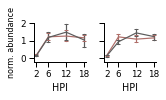

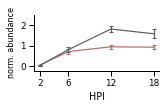

In [113]:
fig, axs = plt.subplots(ncols=2, figsize=(2.4, 1.3), sharey=True)
wide_fig, wide_ax = plt.subplots(figsize=(2.4, 1.5))
axs_dict = dict(zip(['IE', 'E', 'L'], [axs.flatten()[0], axs.flatten()[1], wide_ax]))

for t, data in all_data_mean.loc['ACV 3uM'][all_data_mean.loc['ACV 3uM'].index.get_level_values('temporality').isin(['IE', 'E', 'L'])].reset_index().groupby('temporality'):
    ax = axs_dict[t]
    sns.lineplot(data=data, x='timepoint', y=0, 
                      hue='treatment', palette = [pal[0], pal[-1]], 
                      hue_order = ['ACV', 'DMSO'], 
                      ax=ax, err_style='bars', err_kws = {'capsize': 2}
                     )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([2, 6, 12, 18])
    ax.set_xlabel('HPI')
    ax.set_ylabel('norm. abundance', fontsize=8)
    ax.set_ylim(-.20, 2)
    ax.set_yticks([0, 1, 2])
    
#     annots = add_stars(data.set_index(all_data_mean.loc['ACV 3uM'].index.names).squeeze().unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     ys = data.groupby(['timepoint', 'treatment']).mean().unstack().max(axis=1)
    
#     for (x, y), s in zip(ys.iteritems(), annots):
#         ax.text(x, y+.25, s, ha='center', fontsize=8)

wide_ax.set_ylim(-0.2, 2.5)

fig.tight_layout()
wide_fig.tight_layout()

fig.savefig(r'..\figures\Fig4C_IE-E.png', dpi=1000, bbox_inches='tight')
wide_fig.savefig(r'..\figures\Fig4C_L.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 4D

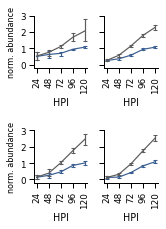

In [112]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2.4, 3.2), sharey=True)
axs_dict = dict(zip(['IE', 'DE', 'LL', 'L'], axs.flatten()))

for t, data in all_data_mean.loc['CDV'][all_data_mean.loc['CDV'].index.get_level_values('temporality').isin(['IE', 'DE', 'LL', 'L'])].reset_index().groupby('temporality'):
    ax = axs_dict[t]
    sns.lineplot(data=data, x='timepoint', y=0, 
                      hue='treatment', palette = [bright_pal[1], pal[-1]], 
                      hue_order = ['CDV', 'PBS'], 
                      ax=ax, err_style='bars', err_kws = {'capsize': 2}
                     )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([24, 48, 72, 96, 120])
    ax.set_xticklabels([24, 48, 72, 96, 120], rotation=90)
    ax.set_xlabel('HPI')
    ax.set_ylabel('norm. abundance', fontsize=8)
    ax.set_ylim(-.20, 3)
    ax.set_yticks([0, 1, 2, 3])
    
#     annots = add_stars(data.set_index(all_data_mean.loc['CDV'].index.names).squeeze().unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     ys = data.set_index(all_data_mean.loc['CDV'].index.names).squeeze().unstack('treatment')['PBS'].groupby('timepoint').apply(lambda x: sns.utils.ci(sns.algorithms.bootstrap(x))[1])
    
#     for (x, y), s in zip(ys.iteritems(), annots):
#         ax.text(x, y+.15, s, ha='center', fontsize=8)

fig.tight_layout()
plt.subplots_adjust(hspace=1.2)

fig.savefig(r'..\figures\Fig4D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 4E

2.0631290667449944


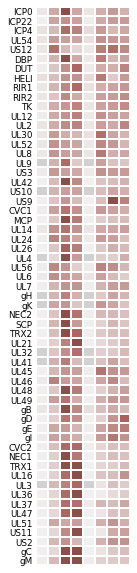

In [51]:
fig, ax = plt.subplots(figsize = (2, 8.07))

cm = sns.light_palette((168/256, 97/256, 92/256), reverse=False, as_cmap=True)
cm.set_over((140/256, 79/256, 74/256))
cm.set_under((210/256, 210/256, 210/256))

data = pd.concat([all_data_mean.loc['ACV 3uM'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['ACV 3uM'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']])[['DMSO', 'ACV']]
dremel = pd.read_csv(r'..\data\Dremel2019_late_classification.csv', index_col=[0, 1]).squeeze().reset_index('gene name', drop=True)
data['classification'] = dremel.reindex(data.index, level='Protein Accession').fillna('')
data = data.reset_index().set_index(['temporality', 'classification', 'Protein Gene', 'Protein Accession']).sort_index()

data = pd.concat([data[data.index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']], sort=False) 

sns.heatmap(data.fillna(-1), 
#             square=True,
            cmap=cm, 
            ax=ax, 
            vmax=data.melt()['value'].describe(percentiles=[.95])['95%'], 
            vmin=0,
            linewidth=1,
            cbar=False,
            yticklabels = data.index.get_level_values('Protein Gene')
           )
print(data.melt()['value'].describe(percentiles=[.95])['95%'],)
ax.tick_params(axis='y', size=0)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# for l in ax.get_yticklabels():
#     l.set_color({'':'black', 'gamma-1':(140/256, 79/256, 74/256), 'gamma-2': bright_pal[1]}[data.reset_index().set_index('Protein Gene').loc[l._text, 'classification'].values[0]])

fig.tight_layout()
fig.savefig(r'..\figures\Fig4E_mean_normalized.svg', dpi=1000, bbox_inches='tight')
plt.show()

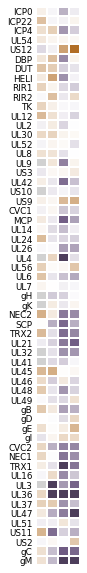

In [49]:
fig, ax = plt.subplots(figsize = (1.3, 8.07))

div_cmap = sns.blend_palette([tuple(np.array([108, 87, 128])/256), '#FFFFFF', tuple(np.array([176, 106, 32])/256)], as_cmap=True)
div_cmap.set_under(tuple(np.array([77, 62, 91])/256))
div_cmap.set_over(tuple(np.array([129, 78, 24])/256))

# div_cmap = sns.blend_palette([pal[-1], '#FFFFFF', hsv1_palette(0)], as_cmap=True)
# div_cmap.set_under('black')
# div_cmap.set_over((140/256, 79/256, 74/256))

ax.set_facecolor((210/256, 210/256, 210/256))

data = pd.concat([all_data_mean.loc['ACV 3uM'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['ACV 3uM'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']])[['DMSO', 'ACV']]
data = np.log2(data['ACV']/data['DMSO'])
# dremel = pd.read_csv(r'..\data\Dremel2019_late_classification.csv', index_col=[0, 1]).squeeze().reset_index('gene name', drop=True)
data['classification'] = dremel.reindex(data.index, level='Protein Accession').fillna('')
data = data.reset_index().set_index(['temporality', 'classification', 'Protein Gene', 'Protein Accession']).sort_index()

data = pd.concat([data[data.index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']], sort=False) 

sns.heatmap(data, 
#             square=True,
            cmap=div_cmap, 
            ax=ax, 
            vmin=-2,
            vmax=2,
            linewidth=1,
            cbar=False,
            yticklabels = data.index.get_level_values('Protein Gene')
           )
ax.tick_params(axis='y', size=0)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig4E_log2FC.svg', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 4F

2.3975944659373454


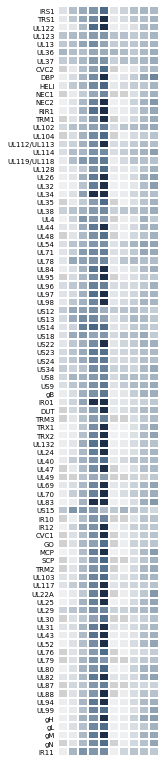

In [16]:
fig, ax = plt.subplots(figsize = (2.4, 10.7))


data = pd.concat([all_data_mean.loc['CDV'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['CDV'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'LL', 'L']])[['PBS', 'CDV']]
idx = data.index.names
data=data.reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
#data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))
data = data.set_index(idx)

cm = sns.light_palette((71/256, 103/256, 133/256), reverse=False, as_cmap=True)
cm.set_over((30/256, 48/256, 72/256))
cm.set_under((210/256, 210/256, 210/256))

sns.heatmap(data.fillna(-1), 
            cmap=cm, 
            ax=ax, 
            vmax=data.melt()['value'].describe(percentiles=[.95])['95%'], 
            vmin=0,
            linewidth=1,
            cbar=False
           )

print(data.melt()['value'].describe(percentiles=[.95])['95%'],)
ax.tick_params(axis='y', size=0)
ax.set_yticks(np.linspace(0.5, ax.get_ylim()[0]-0.5, int(ax.get_ylim()[0])))
ax.set_yticklabels(data.index.get_level_values('Protein Gene'), fontsize=7)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig4F_mean_normalized.svg', dpi=1000, bbox_inches='tight')
plt.show()

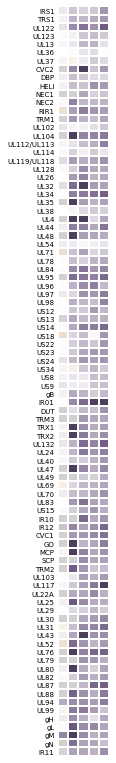

In [50]:
fig, ax = plt.subplots(figsize = (1.7, 10.7))


data = pd.concat([all_data_mean.loc['CDV'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['CDV'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'DE', 'LL', 'L']])[['PBS', 'CDV']]
idx = data.index.names
data=data.reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
#data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))
data = data.set_index(idx)
data = np.log2(data['CDV']/data['PBS'])

div_cmap = sns.blend_palette([tuple(np.array([108, 87, 128])/256), '#FFFFFF', tuple(np.array([176, 106, 32])/256)], as_cmap=True)
div_cmap.set_under(tuple(np.array([77, 62, 91])/256))
div_cmap.set_over(tuple(np.array([129, 78, 24])/256))

# div_cmap = sns.blend_palette([pal[-1], '#FFFFFF', hcmv_palette(0)], as_cmap=True)
# div_cmap.set_over((30/256, 48/256, 72/256))
# div_cmap.set_under('black')

ax.set_facecolor((210/256, 210/256, 210/256))

sns.heatmap(data, 
            cmap=div_cmap, 
            ax=ax, 
            vmax=2, 
            vmin=-2,
            linewidth=1,
            cbar=False
           )

ax.tick_params(axis='y', size=0)
ax.set_yticks(np.linspace(0.5, ax.get_ylim()[0]-0.5, int(ax.get_ylim()[0])))
ax.set_yticklabels(data.index.get_level_values('Protein Gene'), fontsize=7)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\Fig4F_log2FC.svg', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6B

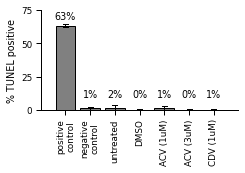

In [87]:
mrc5_samples = ['positive control', 'negative control', 'untreated', 'DMSO', 'ACV (1uM)', 'ACV (3uM)', 'CDV (1uM)']
cell_type = 'MRC5'
x_order = mrc5_samples
offset=5
n = len(mrc5_samples)

fig, ax = plt.subplots(figsize=(3.5, 2.5))

sns.barplot(
    data=pct_apop[cell_type].reset_index(), 
    x='sample', 
    y='OD', 
    order = x_order,
    ax=ax,
    color='grey',
    capsize=0.2,
    errcolor='black',
    errwidth=1,
    linewidth=1,
    edgecolor='k'
)

ax.set_xticklabels(['positive\ncontrol', 'negative\ncontrol', 'untreated', 'DMSO', 'ACV (1uM)', 'ACV (3uM)', 'CDV (1uM)'], rotation=90)
ax.set_ylabel('')
ax.set_xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0, pct_apop[cell_type].groupby('sample').mean().max()+offset, '{:.0f}%'.format(pct_apop[cell_type].groupby('sample').mean().max()), ha='center')

for i, x in enumerate(x_order[1:], 1):
    ax.text(i, 10, '{:.0f}%'.format(pct_apop[cell_type].groupby('sample').mean()[x]), ha='center')

ax.set_xlim(-1, len(x_order))
    
ax.set_ylim(0, 75)
ax.set_yticks([0, 25, 50, 75])
ax.set_ylabel('% TUNEL positive')
   
fig.tight_layout()
fig.savefig(r'..\figures\FigS6B.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6C

1.8006301365191795


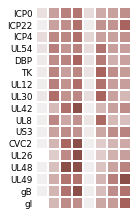

In [106]:
fig, ax = plt.subplots(figsize = (3.1, 3.1))

cm = sns.light_palette((168/256, 97/256, 92/256), reverse=False, as_cmap=True)
cm.set_over((140/256, 79/256, 74/256))
cm.set_under((210/256, 210/256, 210/256))

data = pd.concat([all_data_mean.loc['ACV 1uM'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['ACV 1uM'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']])[['DMSO', 'ACV']]

sns.heatmap(data, 
            square=True,
            cmap=cm, 
            ax=ax, 
            vmax=data.melt()['value'].describe(percentiles=[.95])['95%'], 
            vmin=0,
            linewidth=1,
            cbar=False,
            yticklabels = data.index.get_level_values('Protein Gene')
           )

print(data.melt()['value'].describe(percentiles=[.95])['95%'],)

ax.tick_params(size=0)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\FigS6C_mean_normalized.svg', dpi=1000, bbox_inches='tight')
plt.show()

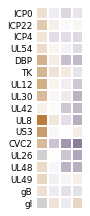

In [107]:
fig, ax = plt.subplots(figsize = (3.1, 3.1))

div_cmap = sns.blend_palette([tuple(np.array([108, 87, 128])/256), '#FFFFFF', tuple(np.array([176, 106, 32])/256)], as_cmap=True)
div_cmap.set_under(tuple(np.array([77, 62, 91])/256))
div_cmap.set_over(tuple(np.array([129, 78, 24])/256))
ax.set_facecolor((210/256, 210/256, 210/256))

data = pd.concat([all_data_mean.loc['ACV 1uM'].unstack(['treatment', 'timepoint'])[all_data_mean.loc['ACV 1uM'].unstack(['treatment', 'timepoint']).index.get_level_values('temporality')==t] for t in ['IE', 'E', 'L']])[['DMSO', 'ACV']]
data = np.log2(data['ACV']/data['DMSO'])
sns.heatmap(data, 
            cmap=div_cmap, 
            square=True,
            ax=ax, 
            vmax=2, 
            vmin=-2,
            linewidth=1,
            cbar=False,
            yticklabels = data.index.get_level_values('Protein Gene')
           )

ax.tick_params(size=0)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.tight_layout()
fig.savefig(r'..\figures\FigS6C_log2FC.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6D

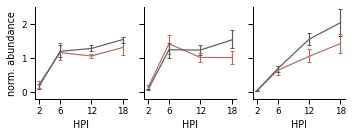

In [89]:
fig, axs = plt.subplots(ncols=3, figsize=(5, 2), sharey=True)
axs_dict = dict(zip(['IE', 'E', 'L'], axs.flatten()))

for t, data in all_data_mean.loc['ACV 1uM'][all_data_mean.loc['ACV 1uM'].index.get_level_values('temporality').isin(['IE', 'E', 'L'])].reset_index().groupby('temporality'):
    ax = axs_dict[t]
    sns.lineplot(data=data, x='timepoint', y=0, 
                      hue='treatment', palette = [pal[0], pal[-1]], 
                      hue_order = ['ACV', 'DMSO'], 
                      ax=ax, err_style='bars', err_kws = {'capsize': 2}
                     )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([2, 6, 12, 18])
    ax.set_xlabel('HPI')
    ax.set_ylabel('norm. abundance')
    ax.set_ylim(-.20, 2.5)
    ax.set_yticks([0, 1, 2])
    
#     annots = add_stars(data.set_index(all_data_mean.loc['ACV 1uM'].index.names).squeeze().unstack('treatment').groupby('timepoint').apply(TTEST).squeeze())
#     ys = data.groupby(['timepoint', 'treatment']).mean().unstack().max(axis=1)
    
#     for (x, y), s in zip(ys.iteritems(), annots):
#         ax.text(x, y+.25, s, ha='center', fontsize=8)

fig.tight_layout()

fig.savefig(r'..\figures\FigS6D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6E

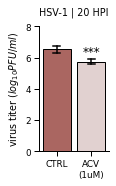

In [98]:
fig, ax = plt.subplots(figsize = (1.7, 2.7))

data=np.log10(titers.loc[['DMSO', 'ACV (1uM)'], :].stack([0, 1]))
sns.barplot(data=data.reset_index(), 
            x='sample', y=0, 
            ax=ax,
            palette=hsv1_palette([10, 200]), 
            capsize=0.2, errwidth=1.5, saturation=1,
            linewidth=1, edgecolor='k', errcolor='k'
            )
ax.set_ylabel('virus titer ($log_{10}PFU/ml$)')
ax.set_title('HSV-1 | 20 HPI', y=1.05)

ax.set_xlabel('')
ax.set_yticks([0, 2, 4, 6, 8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['CTRL', 'ACV\n(1uM)'], va='top')

ax.text(1, np.log10(titers.loc['ACV (1uM)', :]).mean()+.4, add_stars(TTEST(titers.loc[['DMSO', 'ACV (1uM)'], :].unstack().apply(np.log10).unstack('sample'))).values[0], ha='center', fontsize=12)

    
fig.tight_layout()
fig.savefig(r'..\figures\FigS6E.png', dpi=1000, bbox_inches='tight')
plt.show()